This is my notebook for Kaggle's House Prices competition. The objective is to predict house prices in Ames, Iowa.

To start, I imported the necessary packages for this project.

In [1]:
# Import statements...
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor

To start, I need to create the data frames out of the CSV files containing the raw data. I then will merge them into
one large data frame, so that when I am wrangling the data, I do not need to repeat the process for training and testing data.

At the end I will separate the data again.

In [2]:
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")
train_df.head()
print(train_df.shape)
# Concatenate it all
concatenated = pd.concat([train_df.drop(['SalePrice'], axis=1),test_df])
concatenated.shape

(1460, 81)


(2919, 80)

Below, I looked at missing values and decided on how to impute them. For the variables in NoneCols, I assumed that these
were missing from the house, so I filled in the values as "none".

For the variables in modecols, as well as numerical variables in num_mode_cols I used SimpleImputer, filling them in with the most frequent one.

Finally for the numerical values I used their means as they didn't have many missing values.

In [3]:
# Deal with values that are non-numeric
numerical = list( concatenated.loc[:,concatenated.dtypes != 'object'].columns.values )
nonnumeric = list( concatenated.loc[:,concatenated.dtypes == 'object'].columns.values )
numerical_missing = concatenated[numerical].isnull().sum()
numerical_missing=numerical_missing[numerical_missing > 0]
non_numerical_missing = concatenated[nonnumeric].isnull().sum()
non_numerical_missing=non_numerical_missing[non_numerical_missing>0]
print(numerical_missing)
print(non_numerical_missing)
# Fill these features with None
nonecols = ['Alley', 'FireplaceQu', 'PoolQC', 'Fence', 'MiscFeature', 'GarageType', 'GarageQual',
            'GarageFinish', 'GarageCond', 'BsmtFinType2', 'BsmtFinType1', 'BsmtQual', 'BsmtCond', 'BsmtExposure',
            'MasVnrType' ]
concatenated[nonecols] = concatenated[nonecols].fillna('None')
# Fill these cols with the mode
modecols = ['Utilities', 'Exterior1st', 'Exterior2nd', 'Electrical', 'KitchenQual', 'Functional',\
            'SaleType', 'Exterior1st', 'Exterior2nd']
num_mode_cols = ['BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'BsmtFullBath',\
                 'BsmtHalfBath', 'GarageCars', 'GarageArea']
# Fill this one with means
num_mean_cols = ['LotFrontage', 'MasVnrArea']

LotFrontage     486
MasVnrArea       23
BsmtFinSF1        1
BsmtFinSF2        1
BsmtUnfSF         1
TotalBsmtSF       1
BsmtFullBath      2
BsmtHalfBath      2
GarageYrBlt     159
GarageCars        1
GarageArea        1
dtype: int64
MSZoning           4
Alley           2721
Utilities          2
Exterior1st        1
Exterior2nd        1
MasVnrType        24
BsmtQual          81
BsmtCond          82
BsmtExposure      82
BsmtFinType1      79
BsmtFinType2      80
Electrical         1
KitchenQual        1
Functional         2
FireplaceQu     1420
GarageType       157
GarageFinish     159
GarageQual       159
GarageCond       159
PoolQC          2909
Fence           2348
MiscFeature     2814
SaleType           1
dtype: int64


In [4]:
concatenated[num_mean_cols] = concatenated[num_mean_cols].fillna(concatenated[num_mean_cols].mean())
# Use SimpleImputer to fill in the rest with the mode
imp = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
imp.fit(concatenated)
# Do this to ensure column names aren't erased
concatenated[concatenated.columns] = imp.transform(concatenated)

Below I plotted the dependent variable to check it for normality.

C:\Users\warre\anaconda3\envs\HousePrices\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


1.8828757597682129
6.536281860064529


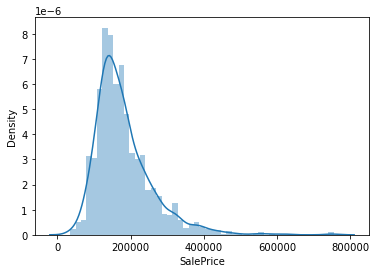

In [5]:
# Let's have a look at SalePrice
sns.distplot(train_df['SalePrice'])
train_df['SalePrice'].describe()
print(train_df['SalePrice'].skew())
print(train_df['SalePrice'].kurt())

Overall the SalePrice is skewed positively, so we might need to give it a log-transformation.
The skew is 1.8828757597682129 and kurtosis 6.536281860064529.

C:\Users\warre\anaconda3\envs\HousePrices\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


0.12134661989685333
0.809519155707878


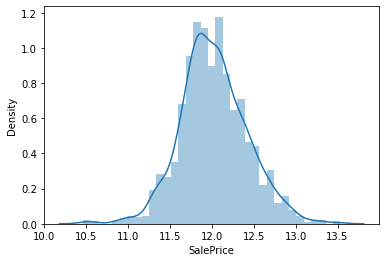

In [6]:
# Transform our dependent variable
train_df['SalePrice'] = np.log1p(train_df['SalePrice'])
sns.distplot(train_df['SalePrice'])
print(train_df['SalePrice'].skew())
print(train_df['SalePrice'].kurt())
# It falls a lot!

After applying a log transformation, the skew is now -0.00466 and kurtosis is 0.9226. The data now looks more normal.

Below I have plotted certain variables against the sale price, to get an idea of what the data looks like.

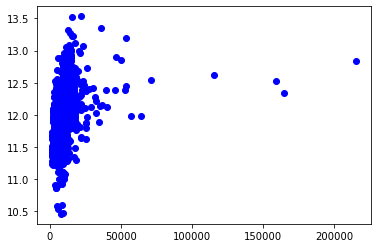

In [7]:
# Lot area v. saleprice
plt.plot(train_df["LotArea"], train_df["SalePrice"], 'bo')
plt.xlabel = "LotArea"
plt.ylabel="SalePrice"
plt.show()


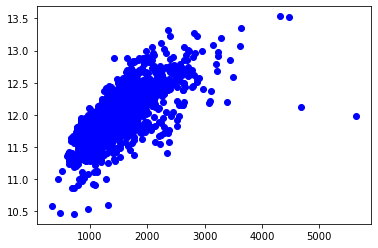

In [8]:
plt.plot(train_df["GrLivArea"], train_df["SalePrice"], 'bo')
plt.xlabel="Greater living area"
plt.ylabel="SalePrice"
plt.show()

I then decided to take a look at the correlation between different variables.

I created a heatmap showing variables of high correlation.

EnclosedPorch   -0.149050
KitchenAbvGr    -0.147548
MSSubClass      -0.073959
LowQualFinSF    -0.037963
YrSold          -0.037263
OverallCond     -0.036868
MiscVal         -0.020021
Id              -0.017942
BsmtHalfBath    -0.005149
BsmtFinSF2       0.004832
3SsnPorch        0.054900
MoSold           0.057330
PoolArea         0.069798
ScreenPorch      0.121208
BedroomAbvGr     0.209043
BsmtUnfSF        0.221985
BsmtFullBath     0.236224
LotArea          0.257320
HalfBath         0.313982
2ndFlrSF         0.319300
OpenPorchSF      0.321053
WoodDeckSF       0.334135
LotFrontage      0.355879
BsmtFinSF1       0.372023
MasVnrArea       0.430809
Fireplaces       0.489450
TotRmsAbvGrd     0.534422
GarageYrBlt      0.541073
YearRemodAdd     0.565608
YearBuilt        0.586570
FullBath         0.594771
1stFlrSF         0.596981
TotalBsmtSF      0.612134
GarageArea       0.650888
GarageCars       0.680625
GrLivArea        0.700927
OverallQual      0.817185
SalePrice        1.000000
Name: SalePr

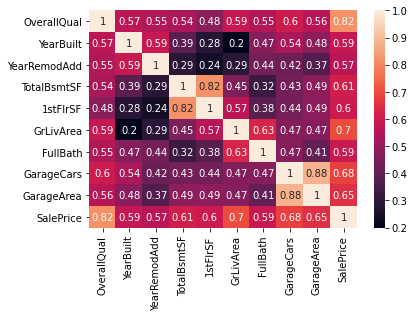

In [9]:
correlation = train_df.corr()
# create a heat map for high correlation
high_corr = correlation.index[abs(correlation["SalePrice"] > 0.55)]
heatmap = sns.heatmap(train_df[high_corr].corr(), annot=True)
print(correlation["SalePrice"].sort_values(ascending=True))

Here, I decided to make MSSubClass, and YrSold categorical. This is because there are only a finite number of types
of homes, and the year sold is not a continuous variable. If year sold were continuous, this would make the model
inaccurate.

In [10]:
# Make these categorical, year is a category and sub class is also
concatenated[["MSSubClass", "YrSold"]] = concatenated[["MSSubClass", "YrSold"]].astype("category")

Above, I created a new variable to reflect the total square footage of the home.

I also created the columns SinMonth and CosMonth, where I took the sine and cosine of the months, to remove seasonal
trends from the data. This is because trends can affect the final output and make it less accurate.

In [11]:
# create total sq ft
concatenated['total_sqft'] = concatenated['GrLivArea'] + concatenated['TotalBsmtSF']
# remove trend seasonality, use sine and cosine
concatenated['CosMonth'] = np.cos(2 * np.pi * concatenated['MoSold'] / 12)
concatenated['SinMonth'] = np.sin(2 * np.pi * concatenated['MoSold'] / 12)
concatenated = concatenated.drop(['MoSold'] ,axis=1)
# Now create dummy vars.

Finally, I created the model and outputs. I first encoded the categorical variables using the get_dummies function.

As mentioned above, I separated the data back into its original training and testing sets here.  I decided to use the
XGBRegressor, a regression model that uses gradient boosting.

In [12]:
concatenated = pd.get_dummies(concatenated)
trainY = train_df['SalePrice']
train_df.index
trainX = concatenated.head(1460)
testX = concatenated.tail(1459)
model = RandomForestRegressor()
model.fit(trainX, trainY)
predictions = np.exp(model.predict(testX))
output=pd.DataFrame()
output['Id'] = testX['Id']
output['SalePrice'] = predictions
output.to_csv('RandomForestModel.csv', index=False)


